In [1]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

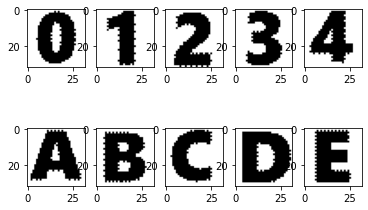

In [3]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 1024])
f=lambda x: x + 60 if x > 4 else x + 48
for i in range(0, 10):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet132/' + chr(f(i)) + str(132) + '.PNG'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    plt.subplot(2,5,i+1)
    plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [4]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, d_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.linear0 = nn.Linear(input_size, d_hidden[0])
        self.activate0 = nn.ReLU()
        self.linear1 = nn.Linear(d_hidden[0], d_hidden[1])
        self.activate1 = nn.ReLU()
        self.linear2 = nn.Linear(d_hidden[1], d_hidden[2])
        self.activate2 = nn.ReLU()
        self.linear3 = nn.Linear(d_hidden[2], d_hidden[3])
        self.activate3 = nn.ReLU()
        self.linear4 = nn.Linear(d_hidden[3],num_classes)
        self.activate4 = nn.Sigmoid()

        
    def forward(self, x):
        res = self.linear0(x)
        res = self.activate0(res)
        res = self.linear1(res)
        res = self.activate1(res)
        res = self.linear2(res)
        res = self.activate2(res)
        res = self.linear3(res)
        res = self.activate3(res)
        res = self.linear4(res)
        res = self.activate4(res)
        return res

In [5]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [6]:
# Parameters of training
learning_rate = 0.001
# Train until the error become the lowest
# get the optimization of MAE or MSE
num_epochs = 600
batch_size, input_size, num_classes = 10, 1024, 1024
d_hidden=[320, 320, 320, 320]

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, d_hidden=d_hidden,num_classes=num_classes).to(device)

# Setup for noise training
if not os.path.exists('./models21'):
    os.mkdir('./models21')
torch.save(model, './models21/net_untrained.pkl')
for i in range(5):
    if not os.path.exists('./models21/' + str(i) + '/'):
        os.mkdir('./models21/' + str(i) + '/')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
# Step 3
model = Perceptron(input_size=input_size, d_hidden=d_hidden, num_classes=num_classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
def train(dataloader, model, num_epochs):
    # research regarding epoch to explain why we need that many iterations (num_epochs)
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = []
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            # data['data'] is each image data in dataset
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(error.shape)
            ERROR_Train.extend(error)
#         print(ERROR_Train)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2499 MAE: 0.4998 Mean Error: 0.0943 STD: 0.4910
[10/600] Loss: 0.1407 MAE: 0.2088 Mean Error: 0.0122 STD: 0.3749
[20/600] Loss: 0.1252 MAE: 0.2573 Mean Error: 0.0034 STD: 0.3538
[30/600] Loss: 0.1146 MAE: 0.2476 Mean Error: 0.0106 STD: 0.3384
[40/600] Loss: 0.0797 MAE: 0.1683 Mean Error: 0.0019 STD: 0.2822
[50/600] Loss: 0.0528 MAE: 0.1043 Mean Error: 0.0041 STD: 0.2297
[60/600] Loss: 0.0380 MAE: 0.0772 Mean Error: -0.0015 STD: 0.1950
[70/600] Loss: 0.0248 MAE: 0.0542 Mean Error: -0.0023 STD: 0.1573
[80/600] Loss: 0.0127 MAE: 0.0261 Mean Error: 0.0007 STD: 0.1126
[90/600] Loss: 0.0089 MAE: 0.0147 Mean Error: -0.0001 STD: 0.0943
[100/600] Loss: 0.0077 MAE: 0.0108 Mean Error: -0.0003 STD: 0.0878
[110/600] Loss: 0.0072 MAE: 0.0091 Mean Error: 0.0001 STD: 0.0846
[120/600] Loss: 0.0069 MAE: 0.0084 Mean Error: 0.0001 STD: 0.0833
[130/600] Loss: 0.0067 MAE: 0.0079 Mean Error: 0.0002 STD: 0.0817
[140/600] Loss: 0.0066 MAE: 0.0076 Mean Error: 0.0002 STD: 0.0810
[150/600] Loss: 0

(10, 1024)


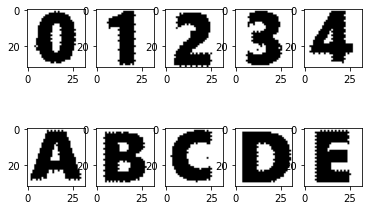

In [9]:
# Step 4
# Step 4a
# TODO create new for dataset 1
if not os.path.exists('./ass2output32'):
    os.mkdir('./ass2output32')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models21/net_trained.pkl')
output_dataset1 = np.zeros([10, 1024])
for i in range(10):
    output_img = output_np[i].reshape(32, 32)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    output_path = './ass2output32/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset1[i] = array


(10, 1024)


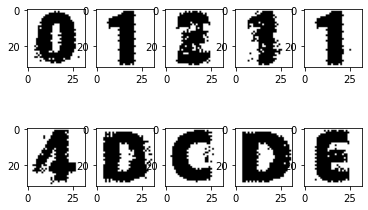

In [11]:
# Step 4
# Step 4b
# Export the image after training
# Before executing this block, create a folder called "output"

# read dataset2 images
dataSet2 = np.zeros([10, 1024])
f=lambda x: x + 60 if x > 4 else x + 48
for i in range(0, 10):
    # TODO Change PNG to jpg
    inputImageDir = './dataSet232/' + chr(f(i)) + str(232) + '.jpg'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
#     plt.subplot(6,6,i+1)
#     plt.imshow(inputImage)
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet2[i] = array
dataSet2 = np.array(dataSet2)

if not os.path.exists('./ass2output322'):
    os.mkdir('./ass2output322')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models21/net_trained.pkl')
output_dataset2 = np.zeros([10, 1024])
output_dataset2_model = model(torch.from_numpy(dataSet2).float())
output_np = output_dataset2_model.detach().numpy()
for i in range(10):
    output_img = output_np[i].reshape(32, 32)*255
    img = Image.fromarray(np.uint8(output_img))
    img = img.convert("1")
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    output_path2 = './ass2output322/' + str(i) + '.png'
    img.save(output_path2)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset2[i] = array

In [12]:
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [13]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [14]:
Fh_array1 = calculateFh(dataSet, output_dataset1)
Ffa_array1 = calculateFfa(dataSet, output_dataset1)
Fh_array2 = calculateFh(dataSet2, output_dataset2)
Ffa_array2 = calculateFfa(dataSet2, output_dataset2)
print(Fh_array2)
print(Ffa_array2)

[0.92592593 0.93425606 0.89220183 0.81998348 0.81663258 0.78437667
 0.76537217 0.75291211 0.75747801 0.74063549]
[0.17384844 0.12653061 0.15       0.14974003 0.14070627 0.14105263
 0.14693356 0.15469304 0.15966242 0.16329094]


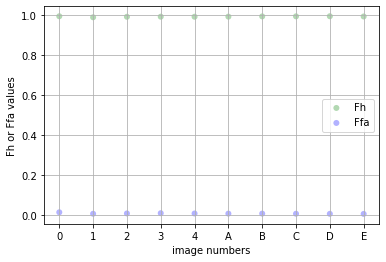

In [16]:
# TODO: Step 4c: Answer 2 questions from canvas
# Q1 Yes there is mismatch
# Q2 Should we compare Dataset2 output vs Dataset1 input? 50-50
# Why or why not?  (Justify your answer with analysis in the report generated in Step 8, below, and think about test, training, and validation datasets).
# TODO visualize Y' (dataset2 output) with X (dataset1 input) to Justify answer (think about test, training)

# Step 4d Graph Fh as a function of Ffa for each exemplar in the input dataset
# Graph for X comparing with Y
import numpy as np
import matplotlib.pyplot as plt

# noiseless
fig, ax = plt.subplots()

Image_name = ['0','1','2','3','4','A','B','C','D','E']

# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array1, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array1, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()


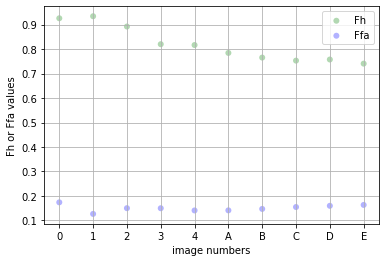

In [17]:
# Graph for X' compare with Y'
# noiseless
fig, ax = plt.subplots()

Image_name = ['0','1','2','3','4','A','B','C','D','E']

# ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Fh_array2, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(Image_name, Ffa_array2, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
# plt.yscale("log")
plt.show()

In [19]:
# Display the Ffa and Fh in a table form X compare with Y

import sys
from prettytable import PrettyTable
table1 = PrettyTable()
table1.field_names = ['Character','Fh','Ffa']

for i in range(10):
    table1.add_row([Image_name[i],Fh_array1[i],round(Ffa_array1[i],5)])
print(table1)

+-----------+--------------------+---------+
| Character |         Fh         |   Ffa   |
+-----------+--------------------+---------+
|     0     | 0.9953051643192489 | 0.01338 |
|     1     | 0.9902097902097902 |  0.006  |
|     2     | 0.992773261065944  | 0.00763 |
|     3     | 0.9932478055367995 |  0.0088 |
|     4     | 0.992984349703184  | 0.00735 |
|     A     | 0.9934867564046895 | 0.00677 |
|     B     | 0.9946447697250982 | 0.00687 |
|     C     | 0.9949494949494949 | 0.00617 |
|     D     | 0.9954313356624563 | 0.00564 |
|     E     | 0.9942266057252827 | 0.00526 |
+-----------+--------------------+---------+


In [20]:
# Display the Ffa and Fh in a table form X' compare with Y'

table2 = PrettyTable()
table2.field_names = ['Character','Fh','Ffa']

for i in range(10):
    table2.add_row([Image_name[i],Fh_array2[i],round(Ffa_array2[i],5)])
print(table2)

+-----------+--------------------+---------+
| Character |         Fh         |   Ffa   |
+-----------+--------------------+---------+
|     0     | 0.9259259259259259 | 0.17385 |
|     1     | 0.9342560553633218 | 0.12653 |
|     2     | 0.8922018348623854 |   0.15  |
|     3     | 0.8199834847233691 | 0.14974 |
|     4     | 0.8166325835037491 | 0.14071 |
|     A     | 0.7843766720171215 | 0.14105 |
|     B     | 0.7653721682847896 | 0.14693 |
|     C     | 0.752912107306742  | 0.15469 |
|     D     | 0.7574780058651026 | 0.15966 |
|     E     | 0.7406354947042108 | 0.16329 |
+-----------+--------------------+---------+


In [23]:
# Step 5
def gaussian_noise(img, mean, sigma, percentage):
    # Generate gauss noise
#     print(img)
    gaussian_out=img
    noise = np.random.normal(mean, sigma, int(percentage*input_size))
    # Add the noise to image
    gp = np.random.uniform(0,255,int(percentage*input_size))
    for i in range(int(percentage*input_size)):
        if gaussian_out[int(gp[i])]==1:
            gaussian_out[int(gp[i])]-=abs(noise[i])
        else:
            gaussian_out[int(gp[i])]+=abs(noise[i])
    #gaussian_out = img + noise
    # Make the value between 0 and 1
    return gaussian_out

gaussian_dataset = np.zeros([5, 9, 10, 1024])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
perc = [0.1, 0.2, 0.25, 0.3, 0.35]

if not os.path.exists('./input_noise22/'):
        os.mkdir('./input_noise22/')
for k in range(5):
    if not os.path.exists('./input_noise22/'+ str(perc[k]) + '/' ):
        os.mkdir('./input_noise22/' + str(perc[k]) + '/' )

for k in range(5):
    for j in range(9):
        if not os.path.exists('./input_noise22/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./input_noise22/' + str(perc[k]) + '/' + str(std[j]))
        for i in range(10):
            inputImage = dataSet2[i].copy()
            gaussian_data = gaussian_noise(inputImage, 0, std[j], perc[k])
            img = gaussian_data.reshape(32, 32)*255
            img = Image.fromarray(np.uint8(img))
            img.convert("1")
            
            inputImageDir = './input_noise22/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(inputImageDir)
            gaussian_dataset[k][j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)

Fh_noise_array1 = np.zeros([5, 9, 10])
Ffa_noise_array1 = np.zeros([5, 9, 10])
Fh_noise_array2 = np.zeros([5, 9, 10])
Ffa_noise_array2 = np.zeros([5, 9, 10])

# Train 9 datasets with noise
if not os.path.exists('./output_noise22/'):
        os.mkdir('./output_noise22/')
for k in range(5):
    if not os.path.exists('./output_noise22/' + str(perc[k]) + '/'):
        os.mkdir('./output_noise22/' + str(perc[k]) + '/')
for k in range(5):
    for j in range(9):
        train_noise_dataset = DigitDataset(dataset = gaussian_dataset[k][j], label_list = dataSet)
        train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
        print('Training dataset with noise standard deviation ' + str(std[j]))
    #     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
        model_noise = Perceptron(input_size=input_size, d_hidden = d_hidden, num_classes=num_classes).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)

        output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
        torch.save(model_noise, './models21/' + str(k) + '/' + 'net_trained_' + str(std[j]) + '.pkl')
        model_noise = torch.load('./models21/' + str(k) + '/' + 'net_trained_'+ str(std[j]) + '.pkl')
    #     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
        print('------------------------------------')
        output_noise = model_noise(torch.from_numpy(dataSet).float())
        output_noise_np = output_noise.detach().numpy()     # Get the output
    #     print(output_noise_np)
        output_noise_dataset = np.zeros([10, 1024])
    #     Make the output only has 0 or 1

        if not os.path.exists('./output_noise22/' + str(perc[k]) + '/' + str(std[j])):
            os.mkdir('./output_noise22/' + str(perc[k]) + '/' + str(std[j]))
    
    
        for i in range(10):
            output_noise_img = output_noise_np[i].reshape(32, 32)*255
            img = Image.fromarray(np.uint8(output_noise_img))
            img = img.convert("1")
            output_path = './output_noise22/' + str(perc[k]) + '/' + str(std[j]) + '/' + str(i) + '.png'
            img.save(output_path)
            data = img.getdata()
            array = np.array(data)/255
            output_noise_dataset[i] = array
#     Calculate Fh and Ffa
        Fh1 = calculateFh(dataSet, output_noise_dataset)
        Ffa1 = calculateFfa(dataSet, output_noise_dataset)
        Fh2 = calculateFh(dataSet2, output_noise_dataset)
        Ffa2 = calculateFfa(dataSet2, output_noise_dataset)
        Fh_noise_array1[k][j] = Fh1
        Ffa_noise_array1[k][j] = Ffa1
        Fh_noise_array2[k][j] = Fh2
        Ffa_noise_array2[k][j] = Ffa2
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

Training dataset with noise standard deviation 0.001
[0/600] Loss: 0.2504 MAE: 0.5003 Mean Error: 0.0937 STD: 0.4915
[10/600] Loss: 0.1422 MAE: 0.2061 Mean Error: 0.0152 STD: 0.3768
[20/600] Loss: 0.1259 MAE: 0.2418 Mean Error: 0.0021 STD: 0.3548
[30/600] Loss: 0.1101 MAE: 0.2284 Mean Error: 0.0025 STD: 0.3318
[40/600] Loss: 0.0889 MAE: 0.1810 Mean Error: 0.0000 STD: 0.2982
[50/600] Loss: 0.0652 MAE: 0.1443 Mean Error: 0.0004 STD: 0.2554
[60/600] Loss: 0.0380 MAE: 0.0844 Mean Error: 0.0001 STD: 0.1948
[70/600] Loss: 0.0190 MAE: 0.0435 Mean Error: -0.0018 STD: 0.1380
[80/600] Loss: 0.0112 MAE: 0.0229 Mean Error: -0.0006 STD: 0.1058
[90/600] Loss: 0.0078 MAE: 0.0141 Mean Error: -0.0005 STD: 0.0886
[100/600] Loss: 0.0068 MAE: 0.0100 Mean Error: -0.0006 STD: 0.0822
[110/600] Loss: 0.0064 MAE: 0.0083 Mean Error: -0.0007 STD: 0.0802
[120/600] Loss: 0.0062 MAE: 0.0077 Mean Error: -0.0005 STD: 0.0788
[130/600] Loss: 0.0061 MAE: 0.0074 Mean Error: -0.0007 STD: 0.0784
[140/600] Loss: 0.0061 MAE:

[10/600] Loss: 0.1393 MAE: 0.2099 Mean Error: 0.0095 STD: 0.3732
[20/600] Loss: 0.1222 MAE: 0.2407 Mean Error: 0.0037 STD: 0.3496
[30/600] Loss: 0.1004 MAE: 0.1983 Mean Error: -0.0026 STD: 0.3169
[40/600] Loss: 0.0860 MAE: 0.1759 Mean Error: 0.0006 STD: 0.2932
[50/600] Loss: 0.0700 MAE: 0.1497 Mean Error: 0.0020 STD: 0.2645
[60/600] Loss: 0.0471 MAE: 0.1093 Mean Error: 0.0018 STD: 0.2171
[70/600] Loss: 0.0183 MAE: 0.0505 Mean Error: 0.0011 STD: 0.1353
[80/600] Loss: 0.0065 MAE: 0.0155 Mean Error: 0.0014 STD: 0.0805
[90/600] Loss: 0.0043 MAE: 0.0075 Mean Error: 0.0009 STD: 0.0659
[100/600] Loss: 0.0037 MAE: 0.0051 Mean Error: 0.0011 STD: 0.0606
[110/600] Loss: 0.0035 MAE: 0.0045 Mean Error: 0.0010 STD: 0.0595
[120/600] Loss: 0.0035 MAE: 0.0042 Mean Error: 0.0010 STD: 0.0593
[130/600] Loss: 0.0033 MAE: 0.0040 Mean Error: 0.0010 STD: 0.0577
[140/600] Loss: 0.0033 MAE: 0.0039 Mean Error: 0.0010 STD: 0.0577
[150/600] Loss: 0.0033 MAE: 0.0038 Mean Error: 0.0010 STD: 0.0577
[160/600] Loss: 0.

[10/600] Loss: 0.1394 MAE: 0.2117 Mean Error: 0.0057 STD: 0.3733
[20/600] Loss: 0.1241 MAE: 0.2558 Mean Error: 0.0024 STD: 0.3522
[30/600] Loss: 0.1043 MAE: 0.2176 Mean Error: -0.0002 STD: 0.3230
[40/600] Loss: 0.0877 MAE: 0.1864 Mean Error: -0.0048 STD: 0.2961
[50/600] Loss: 0.0667 MAE: 0.1489 Mean Error: -0.0001 STD: 0.2582
[60/600] Loss: 0.0354 MAE: 0.0857 Mean Error: -0.0062 STD: 0.1880
[70/600] Loss: 0.0118 MAE: 0.0322 Mean Error: 0.0010 STD: 0.1087
[80/600] Loss: 0.0050 MAE: 0.0116 Mean Error: 0.0005 STD: 0.0706
[90/600] Loss: 0.0038 MAE: 0.0062 Mean Error: 0.0001 STD: 0.0613
[100/600] Loss: 0.0036 MAE: 0.0049 Mean Error: 0.0001 STD: 0.0596
[110/600] Loss: 0.0035 MAE: 0.0044 Mean Error: 0.0002 STD: 0.0594
[120/600] Loss: 0.0035 MAE: 0.0042 Mean Error: 0.0002 STD: 0.0594
[130/600] Loss: 0.0035 MAE: 0.0041 Mean Error: 0.0001 STD: 0.0591
[140/600] Loss: 0.0033 MAE: 0.0039 Mean Error: 0.0001 STD: 0.0572
[150/600] Loss: 0.0032 MAE: 0.0039 Mean Error: 0.0001 STD: 0.0568
[160/600] Loss:

[10/600] Loss: 0.1410 MAE: 0.2081 Mean Error: 0.0137 STD: 0.3753
[20/600] Loss: 0.1260 MAE: 0.2584 Mean Error: 0.0024 STD: 0.3550
[30/600] Loss: 0.1152 MAE: 0.2463 Mean Error: 0.0074 STD: 0.3393
[40/600] Loss: 0.0908 MAE: 0.1799 Mean Error: -0.0025 STD: 0.3014
[50/600] Loss: 0.0700 MAE: 0.1525 Mean Error: -0.0037 STD: 0.2646
[60/600] Loss: 0.0437 MAE: 0.0941 Mean Error: -0.0063 STD: 0.2089
[70/600] Loss: 0.0206 MAE: 0.0492 Mean Error: -0.0020 STD: 0.1434
[80/600] Loss: 0.0102 MAE: 0.0223 Mean Error: 0.0002 STD: 0.1011
[90/600] Loss: 0.0072 MAE: 0.0120 Mean Error: 0.0004 STD: 0.0846
[100/600] Loss: 0.0064 MAE: 0.0086 Mean Error: 0.0003 STD: 0.0799
[110/600] Loss: 0.0063 MAE: 0.0076 Mean Error: 0.0005 STD: 0.0792
[120/600] Loss: 0.0062 MAE: 0.0071 Mean Error: 0.0005 STD: 0.0785
[130/600] Loss: 0.0061 MAE: 0.0070 Mean Error: 0.0006 STD: 0.0783
[140/600] Loss: 0.0061 MAE: 0.0068 Mean Error: 0.0006 STD: 0.0779
[150/600] Loss: 0.0061 MAE: 0.0067 Mean Error: 0.0006 STD: 0.0779
[160/600] Loss:

[10/600] Loss: 0.1406 MAE: 0.2085 Mean Error: 0.0063 STD: 0.3749
[20/600] Loss: 0.1231 MAE: 0.2389 Mean Error: 0.0040 STD: 0.3509
[30/600] Loss: 0.1004 MAE: 0.1989 Mean Error: -0.0003 STD: 0.3169
[40/600] Loss: 0.0840 MAE: 0.1731 Mean Error: -0.0022 STD: 0.2899
[50/600] Loss: 0.0627 MAE: 0.1392 Mean Error: 0.0016 STD: 0.2504
[60/600] Loss: 0.0326 MAE: 0.0778 Mean Error: -0.0046 STD: 0.1806
[70/600] Loss: 0.0120 MAE: 0.0291 Mean Error: -0.0001 STD: 0.1094
[80/600] Loss: 0.0066 MAE: 0.0124 Mean Error: -0.0004 STD: 0.0814
[90/600] Loss: 0.0055 MAE: 0.0078 Mean Error: 0.0002 STD: 0.0740
[100/600] Loss: 0.0051 MAE: 0.0063 Mean Error: 0.0002 STD: 0.0711
[110/600] Loss: 0.0049 MAE: 0.0058 Mean Error: 0.0002 STD: 0.0700
[120/600] Loss: 0.0049 MAE: 0.0056 Mean Error: 0.0002 STD: 0.0699
[130/600] Loss: 0.0047 MAE: 0.0054 Mean Error: -0.0001 STD: 0.0686
[140/600] Loss: 0.0047 MAE: 0.0053 Mean Error: 0.0001 STD: 0.0683
[150/600] Loss: 0.0046 MAE: 0.0052 Mean Error: 0.0001 STD: 0.0678
[160/600] Los

[10/600] Loss: 0.1410 MAE: 0.2092 Mean Error: 0.0101 STD: 0.3754
[20/600] Loss: 0.1255 MAE: 0.2549 Mean Error: 0.0062 STD: 0.3542
[30/600] Loss: 0.1118 MAE: 0.2388 Mean Error: 0.0060 STD: 0.3343
[40/600] Loss: 0.0905 MAE: 0.1798 Mean Error: -0.0029 STD: 0.3008
[50/600] Loss: 0.0720 MAE: 0.1556 Mean Error: -0.0013 STD: 0.2684
[60/600] Loss: 0.0436 MAE: 0.0974 Mean Error: -0.0023 STD: 0.2089
[70/600] Loss: 0.0229 MAE: 0.0524 Mean Error: -0.0018 STD: 0.1514
[80/600] Loss: 0.0122 MAE: 0.0257 Mean Error: 0.0007 STD: 0.1104
[90/600] Loss: 0.0083 MAE: 0.0145 Mean Error: -0.0001 STD: 0.0910
[100/600] Loss: 0.0073 MAE: 0.0102 Mean Error: 0.0000 STD: 0.0856
[110/600] Loss: 0.0071 MAE: 0.0087 Mean Error: 0.0000 STD: 0.0841
[120/600] Loss: 0.0070 MAE: 0.0081 Mean Error: 0.0001 STD: 0.0834
[130/600] Loss: 0.0068 MAE: 0.0078 Mean Error: -0.0001 STD: 0.0826
[140/600] Loss: 0.0066 MAE: 0.0075 Mean Error: -0.0001 STD: 0.0811
[150/600] Loss: 0.0064 MAE: 0.0074 Mean Error: -0.0001 STD: 0.0802
[160/600] L

[20/600] Loss: 0.1218 MAE: 0.2427 Mean Error: 0.0028 STD: 0.3490
[30/600] Loss: 0.1010 MAE: 0.1991 Mean Error: -0.0015 STD: 0.3178
[40/600] Loss: 0.0860 MAE: 0.1782 Mean Error: 0.0003 STD: 0.2933
[50/600] Loss: 0.0684 MAE: 0.1486 Mean Error: -0.0007 STD: 0.2616
[60/600] Loss: 0.0401 MAE: 0.0962 Mean Error: -0.0049 STD: 0.2002
[70/600] Loss: 0.0172 MAE: 0.0434 Mean Error: -0.0031 STD: 0.1311
[80/600] Loss: 0.0085 MAE: 0.0207 Mean Error: 0.0005 STD: 0.0923
[90/600] Loss: 0.0051 MAE: 0.0109 Mean Error: 0.0011 STD: 0.0717
[100/600] Loss: 0.0042 MAE: 0.0069 Mean Error: 0.0010 STD: 0.0650
[110/600] Loss: 0.0040 MAE: 0.0056 Mean Error: 0.0010 STD: 0.0631
[120/600] Loss: 0.0039 MAE: 0.0051 Mean Error: 0.0010 STD: 0.0627
[130/600] Loss: 0.0038 MAE: 0.0048 Mean Error: 0.0011 STD: 0.0619
[140/600] Loss: 0.0037 MAE: 0.0047 Mean Error: 0.0012 STD: 0.0611
[150/600] Loss: 0.0037 MAE: 0.0046 Mean Error: 0.0011 STD: 0.0610
[160/600] Loss: 0.0036 MAE: 0.0045 Mean Error: 0.0010 STD: 0.0603
[170/600] Loss

[30/600] Loss: 0.0984 MAE: 0.1948 Mean Error: -0.0033 STD: 0.3138
[40/600] Loss: 0.0833 MAE: 0.1700 Mean Error: -0.0018 STD: 0.2886
[50/600] Loss: 0.0602 MAE: 0.1331 Mean Error: -0.0010 STD: 0.2455
[60/600] Loss: 0.0334 MAE: 0.0749 Mean Error: -0.0012 STD: 0.1828
[70/600] Loss: 0.0145 MAE: 0.0345 Mean Error: -0.0014 STD: 0.1205
[80/600] Loss: 0.0080 MAE: 0.0156 Mean Error: -0.0007 STD: 0.0896
[90/600] Loss: 0.0066 MAE: 0.0097 Mean Error: -0.0006 STD: 0.0814
[100/600] Loss: 0.0062 MAE: 0.0078 Mean Error: -0.0007 STD: 0.0789
[110/600] Loss: 0.0060 MAE: 0.0070 Mean Error: -0.0007 STD: 0.0774
[120/600] Loss: 0.0060 MAE: 0.0068 Mean Error: -0.0006 STD: 0.0773
[130/600] Loss: 0.0060 MAE: 0.0066 Mean Error: -0.0007 STD: 0.0772
[140/600] Loss: 0.0059 MAE: 0.0066 Mean Error: -0.0006 STD: 0.0769
[150/600] Loss: 0.0058 MAE: 0.0065 Mean Error: -0.0004 STD: 0.0760
[160/600] Loss: 0.0058 MAE: 0.0064 Mean Error: -0.0005 STD: 0.0760
[170/600] Loss: 0.0058 MAE: 0.0063 Mean Error: -0.0005 STD: 0.0759
[1

[30/600] Loss: 0.1001 MAE: 0.2000 Mean Error: -0.0023 STD: 0.3165
[40/600] Loss: 0.0843 MAE: 0.1729 Mean Error: -0.0005 STD: 0.2904
[50/600] Loss: 0.0649 MAE: 0.1410 Mean Error: 0.0017 STD: 0.2547
[60/600] Loss: 0.0390 MAE: 0.0862 Mean Error: 0.0001 STD: 0.1974
[70/600] Loss: 0.0217 MAE: 0.0492 Mean Error: -0.0019 STD: 0.1474
[80/600] Loss: 0.0094 MAE: 0.0213 Mean Error: -0.0002 STD: 0.0971
[90/600] Loss: 0.0064 MAE: 0.0102 Mean Error: -0.0001 STD: 0.0797
[100/600] Loss: 0.0057 MAE: 0.0074 Mean Error: 0.0000 STD: 0.0757
[110/600] Loss: 0.0054 MAE: 0.0066 Mean Error: -0.0001 STD: 0.0736
[120/600] Loss: 0.0053 MAE: 0.0063 Mean Error: -0.0001 STD: 0.0729
[130/600] Loss: 0.0053 MAE: 0.0060 Mean Error: -0.0000 STD: 0.0726
[140/600] Loss: 0.0052 MAE: 0.0059 Mean Error: -0.0001 STD: 0.0720
[150/600] Loss: 0.0052 MAE: 0.0058 Mean Error: -0.0001 STD: 0.0718
[160/600] Loss: 0.0050 MAE: 0.0056 Mean Error: -0.0002 STD: 0.0707
[170/600] Loss: 0.0050 MAE: 0.0056 Mean Error: -0.0001 STD: 0.0706
[180/

[30/600] Loss: 0.1009 MAE: 0.2012 Mean Error: 0.0003 STD: 0.3177
[40/600] Loss: 0.0844 MAE: 0.1750 Mean Error: -0.0016 STD: 0.2905
[50/600] Loss: 0.0638 MAE: 0.1418 Mean Error: -0.0029 STD: 0.2526
[60/600] Loss: 0.0337 MAE: 0.0794 Mean Error: 0.0002 STD: 0.1836
[70/600] Loss: 0.0120 MAE: 0.0315 Mean Error: -0.0000 STD: 0.1094
[80/600] Loss: 0.0057 MAE: 0.0119 Mean Error: -0.0003 STD: 0.0755
[90/600] Loss: 0.0046 MAE: 0.0069 Mean Error: -0.0004 STD: 0.0681
[100/600] Loss: 0.0042 MAE: 0.0055 Mean Error: -0.0006 STD: 0.0652
[110/600] Loss: 0.0042 MAE: 0.0051 Mean Error: -0.0003 STD: 0.0646
[120/600] Loss: 0.0041 MAE: 0.0048 Mean Error: -0.0004 STD: 0.0641
[130/600] Loss: 0.0040 MAE: 0.0046 Mean Error: -0.0003 STD: 0.0633
[140/600] Loss: 0.0040 MAE: 0.0045 Mean Error: -0.0003 STD: 0.0633
[150/600] Loss: 0.0040 MAE: 0.0045 Mean Error: -0.0002 STD: 0.0631
[160/600] Loss: 0.0039 MAE: 0.0044 Mean Error: -0.0002 STD: 0.0625
[170/600] Loss: 0.0039 MAE: 0.0044 Mean Error: -0.0002 STD: 0.0625
[180

[30/600] Loss: 0.1026 MAE: 0.2082 Mean Error: -0.0034 STD: 0.3204
[40/600] Loss: 0.0866 MAE: 0.1824 Mean Error: -0.0019 STD: 0.2943
[50/600] Loss: 0.0656 MAE: 0.1457 Mean Error: -0.0027 STD: 0.2560
[60/600] Loss: 0.0343 MAE: 0.0800 Mean Error: 0.0017 STD: 0.1851
[70/600] Loss: 0.0145 MAE: 0.0343 Mean Error: 0.0009 STD: 0.1204
[80/600] Loss: 0.0080 MAE: 0.0150 Mean Error: 0.0004 STD: 0.0894
[90/600] Loss: 0.0067 MAE: 0.0093 Mean Error: 0.0002 STD: 0.0821
[100/600] Loss: 0.0065 MAE: 0.0078 Mean Error: 0.0001 STD: 0.0805
[110/600] Loss: 0.0065 MAE: 0.0073 Mean Error: 0.0002 STD: 0.0804
[120/600] Loss: 0.0065 MAE: 0.0071 Mean Error: 0.0002 STD: 0.0803
[130/600] Loss: 0.0063 MAE: 0.0070 Mean Error: 0.0003 STD: 0.0796
[140/600] Loss: 0.0063 MAE: 0.0069 Mean Error: 0.0002 STD: 0.0791
[150/600] Loss: 0.0063 MAE: 0.0068 Mean Error: 0.0002 STD: 0.0791
[160/600] Loss: 0.0063 MAE: 0.0068 Mean Error: 0.0002 STD: 0.0791
[170/600] Loss: 0.0062 MAE: 0.0067 Mean Error: 0.0003 STD: 0.0785
[180/600] Loss

[30/600] Loss: 0.1122 MAE: 0.2399 Mean Error: 0.0034 STD: 0.3350
[40/600] Loss: 0.0895 MAE: 0.1779 Mean Error: -0.0023 STD: 0.2992
[50/600] Loss: 0.0608 MAE: 0.1408 Mean Error: -0.0018 STD: 0.2465
[60/600] Loss: 0.0265 MAE: 0.0621 Mean Error: -0.0055 STD: 0.1628
[70/600] Loss: 0.0116 MAE: 0.0261 Mean Error: -0.0010 STD: 0.1079
[80/600] Loss: 0.0071 MAE: 0.0127 Mean Error: -0.0009 STD: 0.0844
[90/600] Loss: 0.0062 MAE: 0.0085 Mean Error: -0.0006 STD: 0.0787
[100/600] Loss: 0.0060 MAE: 0.0073 Mean Error: -0.0005 STD: 0.0776
[110/600] Loss: 0.0060 MAE: 0.0069 Mean Error: -0.0005 STD: 0.0773
[120/600] Loss: 0.0059 MAE: 0.0066 Mean Error: -0.0003 STD: 0.0767
[130/600] Loss: 0.0059 MAE: 0.0065 Mean Error: -0.0004 STD: 0.0766
[140/600] Loss: 0.0059 MAE: 0.0065 Mean Error: -0.0004 STD: 0.0766
[150/600] Loss: 0.0059 MAE: 0.0064 Mean Error: -0.0004 STD: 0.0766
[160/600] Loss: 0.0059 MAE: 0.0064 Mean Error: -0.0004 STD: 0.0766
[170/600] Loss: 0.0059 MAE: 0.0064 Mean Error: -0.0004 STD: 0.0766
[18

[30/600] Loss: 0.1011 MAE: 0.2059 Mean Error: 0.0003 STD: 0.3179
[40/600] Loss: 0.0859 MAE: 0.1764 Mean Error: -0.0035 STD: 0.2931
[50/600] Loss: 0.0705 MAE: 0.1506 Mean Error: -0.0005 STD: 0.2656
[60/600] Loss: 0.0459 MAE: 0.1040 Mean Error: -0.0021 STD: 0.2142
[70/600] Loss: 0.0250 MAE: 0.0564 Mean Error: -0.0021 STD: 0.1581
[80/600] Loss: 0.0109 MAE: 0.0247 Mean Error: -0.0008 STD: 0.1046
[90/600] Loss: 0.0071 MAE: 0.0119 Mean Error: 0.0004 STD: 0.0844
[100/600] Loss: 0.0065 MAE: 0.0083 Mean Error: 0.0002 STD: 0.0804
[110/600] Loss: 0.0063 MAE: 0.0074 Mean Error: 0.0005 STD: 0.0793
[120/600] Loss: 0.0063 MAE: 0.0070 Mean Error: 0.0003 STD: 0.0791
[130/600] Loss: 0.0063 MAE: 0.0069 Mean Error: 0.0004 STD: 0.0791
[140/600] Loss: 0.0063 MAE: 0.0068 Mean Error: 0.0004 STD: 0.0791
[150/600] Loss: 0.0063 MAE: 0.0068 Mean Error: 0.0004 STD: 0.0791
[160/600] Loss: 0.0063 MAE: 0.0067 Mean Error: 0.0004 STD: 0.0791
[170/600] Loss: 0.0063 MAE: 0.0067 Mean Error: 0.0004 STD: 0.0791
[180/600] Lo

[30/600] Loss: 0.1096 MAE: 0.2313 Mean Error: 0.0077 STD: 0.3310
[40/600] Loss: 0.0887 MAE: 0.1782 Mean Error: -0.0003 STD: 0.2979
[50/600] Loss: 0.0743 MAE: 0.1562 Mean Error: -0.0045 STD: 0.2725
[60/600] Loss: 0.0519 MAE: 0.1165 Mean Error: 0.0006 STD: 0.2278
[70/600] Loss: 0.0305 MAE: 0.0712 Mean Error: -0.0005 STD: 0.1746
[80/600] Loss: 0.0147 MAE: 0.0373 Mean Error: -0.0004 STD: 0.1211
[90/600] Loss: 0.0070 MAE: 0.0165 Mean Error: -0.0008 STD: 0.0835
[100/600] Loss: 0.0050 MAE: 0.0091 Mean Error: -0.0000 STD: 0.0707
[110/600] Loss: 0.0048 MAE: 0.0068 Mean Error: 0.0001 STD: 0.0690
[120/600] Loss: 0.0047 MAE: 0.0061 Mean Error: 0.0001 STD: 0.0684
[130/600] Loss: 0.0045 MAE: 0.0057 Mean Error: 0.0001 STD: 0.0674
[140/600] Loss: 0.0045 MAE: 0.0055 Mean Error: 0.0002 STD: 0.0671
[150/600] Loss: 0.0044 MAE: 0.0053 Mean Error: 0.0001 STD: 0.0664
[160/600] Loss: 0.0044 MAE: 0.0052 Mean Error: 0.0000 STD: 0.0664
[170/600] Loss: 0.0044 MAE: 0.0052 Mean Error: 0.0001 STD: 0.0663
[180/600] L

[30/600] Loss: 0.1088 MAE: 0.2287 Mean Error: 0.0020 STD: 0.3299
[40/600] Loss: 0.0885 MAE: 0.1824 Mean Error: -0.0026 STD: 0.2976
[50/600] Loss: 0.0610 MAE: 0.1387 Mean Error: -0.0065 STD: 0.2468
[60/600] Loss: 0.0300 MAE: 0.0671 Mean Error: -0.0077 STD: 0.1729
[70/600] Loss: 0.0147 MAE: 0.0306 Mean Error: -0.0017 STD: 0.1211
[80/600] Loss: 0.0100 MAE: 0.0171 Mean Error: -0.0014 STD: 0.1002
[90/600] Loss: 0.0087 MAE: 0.0120 Mean Error: -0.0013 STD: 0.0932
[100/600] Loss: 0.0081 MAE: 0.0100 Mean Error: -0.0011 STD: 0.0902
[110/600] Loss: 0.0079 MAE: 0.0093 Mean Error: -0.0011 STD: 0.0891
[120/600] Loss: 0.0077 MAE: 0.0089 Mean Error: -0.0009 STD: 0.0880
[130/600] Loss: 0.0076 MAE: 0.0086 Mean Error: -0.0008 STD: 0.0874
[140/600] Loss: 0.0076 MAE: 0.0085 Mean Error: -0.0008 STD: 0.0873
[150/600] Loss: 0.0076 MAE: 0.0084 Mean Error: -0.0008 STD: 0.0873
[160/600] Loss: 0.0076 MAE: 0.0084 Mean Error: -0.0007 STD: 0.0872
[170/600] Loss: 0.0075 MAE: 0.0083 Mean Error: -0.0007 STD: 0.0868
[18

[20/600] Loss: 0.1255 MAE: 0.2519 Mean Error: 0.0054 STD: 0.3543
[30/600] Loss: 0.1102 MAE: 0.2335 Mean Error: 0.0034 STD: 0.3319
[40/600] Loss: 0.0896 MAE: 0.1796 Mean Error: -0.0005 STD: 0.2994
[50/600] Loss: 0.0751 MAE: 0.1574 Mean Error: -0.0031 STD: 0.2740
[60/600] Loss: 0.0569 MAE: 0.1268 Mean Error: 0.0015 STD: 0.2385
[70/600] Loss: 0.0319 MAE: 0.0753 Mean Error: -0.0019 STD: 0.1786
[80/600] Loss: 0.0125 MAE: 0.0352 Mean Error: 0.0009 STD: 0.1119
[90/600] Loss: 0.0050 MAE: 0.0112 Mean Error: 0.0002 STD: 0.0709
[100/600] Loss: 0.0039 MAE: 0.0062 Mean Error: 0.0002 STD: 0.0626
[110/600] Loss: 0.0036 MAE: 0.0048 Mean Error: 0.0006 STD: 0.0598
[120/600] Loss: 0.0035 MAE: 0.0044 Mean Error: 0.0005 STD: 0.0594
[130/600] Loss: 0.0035 MAE: 0.0042 Mean Error: 0.0006 STD: 0.0593
[140/600] Loss: 0.0035 MAE: 0.0041 Mean Error: 0.0006 STD: 0.0593
[150/600] Loss: 0.0034 MAE: 0.0040 Mean Error: 0.0006 STD: 0.0585
[160/600] Loss: 0.0034 MAE: 0.0039 Mean Error: 0.0006 STD: 0.0585
[170/600] Loss:

[30/600] Loss: 0.1006 MAE: 0.2016 Mean Error: -0.0020 STD: 0.3173
[40/600] Loss: 0.0837 MAE: 0.1723 Mean Error: -0.0001 STD: 0.2894
[50/600] Loss: 0.0618 MAE: 0.1354 Mean Error: 0.0019 STD: 0.2485
[60/600] Loss: 0.0378 MAE: 0.0839 Mean Error: -0.0019 STD: 0.1945
[70/600] Loss: 0.0218 MAE: 0.0495 Mean Error: -0.0025 STD: 0.1477
[80/600] Loss: 0.0104 MAE: 0.0232 Mean Error: -0.0015 STD: 0.1018
[90/600] Loss: 0.0068 MAE: 0.0115 Mean Error: -0.0010 STD: 0.0822
[100/600] Loss: 0.0060 MAE: 0.0081 Mean Error: -0.0007 STD: 0.0776
[110/600] Loss: 0.0058 MAE: 0.0071 Mean Error: -0.0006 STD: 0.0759
[120/600] Loss: 0.0056 MAE: 0.0066 Mean Error: -0.0007 STD: 0.0747
[130/600] Loss: 0.0055 MAE: 0.0063 Mean Error: -0.0008 STD: 0.0740
[140/600] Loss: 0.0053 MAE: 0.0061 Mean Error: -0.0008 STD: 0.0729
[150/600] Loss: 0.0053 MAE: 0.0060 Mean Error: -0.0008 STD: 0.0727
[160/600] Loss: 0.0053 MAE: 0.0059 Mean Error: -0.0008 STD: 0.0727
[170/600] Loss: 0.0053 MAE: 0.0058 Mean Error: -0.0008 STD: 0.0727
[18

[30/600] Loss: 0.1057 MAE: 0.2212 Mean Error: -0.0002 STD: 0.3251
[40/600] Loss: 0.0871 MAE: 0.1776 Mean Error: -0.0022 STD: 0.2951
[50/600] Loss: 0.0689 MAE: 0.1501 Mean Error: -0.0060 STD: 0.2625
[60/600] Loss: 0.0434 MAE: 0.0981 Mean Error: -0.0063 STD: 0.2082
[70/600] Loss: 0.0235 MAE: 0.0559 Mean Error: -0.0010 STD: 0.1534
[80/600] Loss: 0.0084 MAE: 0.0227 Mean Error: -0.0005 STD: 0.0918
[90/600] Loss: 0.0044 MAE: 0.0091 Mean Error: -0.0003 STD: 0.0662
[100/600] Loss: 0.0037 MAE: 0.0056 Mean Error: -0.0002 STD: 0.0607
[110/600] Loss: 0.0035 MAE: 0.0046 Mean Error: -0.0001 STD: 0.0593
[120/600] Loss: 0.0034 MAE: 0.0042 Mean Error: -0.0001 STD: 0.0585
[130/600] Loss: 0.0033 MAE: 0.0040 Mean Error: 0.0001 STD: 0.0571
[140/600] Loss: 0.0032 MAE: 0.0039 Mean Error: 0.0001 STD: 0.0568
[150/600] Loss: 0.0032 MAE: 0.0038 Mean Error: 0.0001 STD: 0.0568
[160/600] Loss: 0.0032 MAE: 0.0037 Mean Error: 0.0001 STD: 0.0568
[170/600] Loss: 0.0032 MAE: 0.0037 Mean Error: 0.0001 STD: 0.0568
[180/60

[30/600] Loss: 0.1010 MAE: 0.2006 Mean Error: -0.0027 STD: 0.3178
[40/600] Loss: 0.0825 MAE: 0.1710 Mean Error: -0.0017 STD: 0.2872
[50/600] Loss: 0.0611 MAE: 0.1346 Mean Error: 0.0023 STD: 0.2471
[60/600] Loss: 0.0357 MAE: 0.0818 Mean Error: 0.0001 STD: 0.1889
[70/600] Loss: 0.0157 MAE: 0.0399 Mean Error: -0.0010 STD: 0.1255
[80/600] Loss: 0.0066 MAE: 0.0145 Mean Error: 0.0000 STD: 0.0810
[90/600] Loss: 0.0050 MAE: 0.0081 Mean Error: 0.0004 STD: 0.0709
[100/600] Loss: 0.0046 MAE: 0.0061 Mean Error: 0.0005 STD: 0.0681
[110/600] Loss: 0.0045 MAE: 0.0055 Mean Error: 0.0006 STD: 0.0672
[120/600] Loss: 0.0045 MAE: 0.0053 Mean Error: 0.0006 STD: 0.0671
[130/600] Loss: 0.0045 MAE: 0.0052 Mean Error: 0.0007 STD: 0.0668
[140/600] Loss: 0.0044 MAE: 0.0050 Mean Error: 0.0007 STD: 0.0663
[150/600] Loss: 0.0044 MAE: 0.0050 Mean Error: 0.0007 STD: 0.0663
[160/600] Loss: 0.0044 MAE: 0.0050 Mean Error: 0.0006 STD: 0.0661
[170/600] Loss: 0.0043 MAE: 0.0049 Mean Error: 0.0006 STD: 0.0656
[180/600] Loss

[30/600] Loss: 0.1078 MAE: 0.2269 Mean Error: 0.0034 STD: 0.3283
[40/600] Loss: 0.0894 MAE: 0.1813 Mean Error: -0.0024 STD: 0.2989
[50/600] Loss: 0.0748 MAE: 0.1581 Mean Error: -0.0001 STD: 0.2736
[60/600] Loss: 0.0537 MAE: 0.1218 Mean Error: 0.0015 STD: 0.2318
[70/600] Loss: 0.0306 MAE: 0.0725 Mean Error: -0.0018 STD: 0.1749
[80/600] Loss: 0.0122 MAE: 0.0327 Mean Error: 0.0010 STD: 0.1106
[90/600] Loss: 0.0060 MAE: 0.0115 Mean Error: 0.0008 STD: 0.0776
[100/600] Loss: 0.0050 MAE: 0.0074 Mean Error: 0.0008 STD: 0.0707
[110/600] Loss: 0.0047 MAE: 0.0060 Mean Error: 0.0005 STD: 0.0686
[120/600] Loss: 0.0046 MAE: 0.0056 Mean Error: 0.0004 STD: 0.0677
[130/600] Loss: 0.0045 MAE: 0.0053 Mean Error: 0.0004 STD: 0.0671
[140/600] Loss: 0.0045 MAE: 0.0052 Mean Error: 0.0004 STD: 0.0671
[150/600] Loss: 0.0045 MAE: 0.0051 Mean Error: 0.0004 STD: 0.0671
[160/600] Loss: 0.0045 MAE: 0.0051 Mean Error: 0.0004 STD: 0.0671
[170/600] Loss: 0.0045 MAE: 0.0051 Mean Error: 0.0004 STD: 0.0670
[180/600] Loss

[40/600] Loss: 0.0883 MAE: 0.1811 Mean Error: -0.0037 STD: 0.2971
[50/600] Loss: 0.0723 MAE: 0.1537 Mean Error: -0.0016 STD: 0.2688
[60/600] Loss: 0.0488 MAE: 0.1099 Mean Error: -0.0007 STD: 0.2210
[70/600] Loss: 0.0261 MAE: 0.0614 Mean Error: -0.0047 STD: 0.1614
[80/600] Loss: 0.0097 MAE: 0.0248 Mean Error: -0.0014 STD: 0.0984
[90/600] Loss: 0.0050 MAE: 0.0104 Mean Error: -0.0003 STD: 0.0704
[100/600] Loss: 0.0041 MAE: 0.0061 Mean Error: -0.0004 STD: 0.0640
[110/600] Loss: 0.0038 MAE: 0.0049 Mean Error: -0.0003 STD: 0.0617
[120/600] Loss: 0.0037 MAE: 0.0045 Mean Error: -0.0002 STD: 0.0610
[130/600] Loss: 0.0037 MAE: 0.0044 Mean Error: -0.0002 STD: 0.0610
[140/600] Loss: 0.0037 MAE: 0.0043 Mean Error: -0.0001 STD: 0.0606
[150/600] Loss: 0.0036 MAE: 0.0042 Mean Error: -0.0002 STD: 0.0602
[160/600] Loss: 0.0036 MAE: 0.0042 Mean Error: -0.0001 STD: 0.0602
[170/600] Loss: 0.0036 MAE: 0.0041 Mean Error: -0.0001 STD: 0.0601
[180/600] Loss: 0.0036 MAE: 0.0041 Mean Error: -0.0001 STD: 0.0601
[

[30/600] Loss: 0.1092 MAE: 0.2366 Mean Error: 0.0061 STD: 0.3304
[40/600] Loss: 0.0882 MAE: 0.1785 Mean Error: -0.0052 STD: 0.2969
[50/600] Loss: 0.0700 MAE: 0.1486 Mean Error: 0.0038 STD: 0.2646
[60/600] Loss: 0.0435 MAE: 0.0979 Mean Error: -0.0001 STD: 0.2085
[70/600] Loss: 0.0219 MAE: 0.0524 Mean Error: 0.0011 STD: 0.1479
[80/600] Loss: 0.0098 MAE: 0.0225 Mean Error: 0.0009 STD: 0.0991
[90/600] Loss: 0.0063 MAE: 0.0115 Mean Error: 0.0016 STD: 0.0793
[100/600] Loss: 0.0052 MAE: 0.0077 Mean Error: 0.0018 STD: 0.0723
[110/600] Loss: 0.0049 MAE: 0.0064 Mean Error: 0.0018 STD: 0.0698
[120/600] Loss: 0.0048 MAE: 0.0059 Mean Error: 0.0018 STD: 0.0693
[130/600] Loss: 0.0048 MAE: 0.0056 Mean Error: 0.0018 STD: 0.0692
[140/600] Loss: 0.0048 MAE: 0.0055 Mean Error: 0.0018 STD: 0.0692
[150/600] Loss: 0.0047 MAE: 0.0054 Mean Error: 0.0020 STD: 0.0687
[160/600] Loss: 0.0047 MAE: 0.0053 Mean Error: 0.0019 STD: 0.0685
[170/600] Loss: 0.0047 MAE: 0.0053 Mean Error: 0.0020 STD: 0.0683
[180/600] Loss:

[30/600] Loss: 0.1151 MAE: 0.2478 Mean Error: 0.0054 STD: 0.3392
[40/600] Loss: 0.0932 MAE: 0.1866 Mean Error: -0.0040 STD: 0.3052
[50/600] Loss: 0.0762 MAE: 0.1611 Mean Error: -0.0004 STD: 0.2761
[60/600] Loss: 0.0490 MAE: 0.1102 Mean Error: -0.0019 STD: 0.2214
[70/600] Loss: 0.0237 MAE: 0.0570 Mean Error: -0.0007 STD: 0.1540
[80/600] Loss: 0.0110 MAE: 0.0234 Mean Error: 0.0001 STD: 0.1051
[90/600] Loss: 0.0076 MAE: 0.0127 Mean Error: 0.0007 STD: 0.0874
[100/600] Loss: 0.0066 MAE: 0.0092 Mean Error: 0.0009 STD: 0.0814
[110/600] Loss: 0.0065 MAE: 0.0080 Mean Error: 0.0008 STD: 0.0804
[120/600] Loss: 0.0064 MAE: 0.0075 Mean Error: 0.0009 STD: 0.0798
[130/600] Loss: 0.0062 MAE: 0.0072 Mean Error: 0.0009 STD: 0.0786
[140/600] Loss: 0.0062 MAE: 0.0071 Mean Error: 0.0008 STD: 0.0785
[150/600] Loss: 0.0061 MAE: 0.0069 Mean Error: 0.0007 STD: 0.0779
[160/600] Loss: 0.0061 MAE: 0.0068 Mean Error: 0.0008 STD: 0.0779
[170/600] Loss: 0.0061 MAE: 0.0067 Mean Error: 0.0008 STD: 0.0779
[180/600] Los

NameError: name 'Fh_noise_array' is not defined

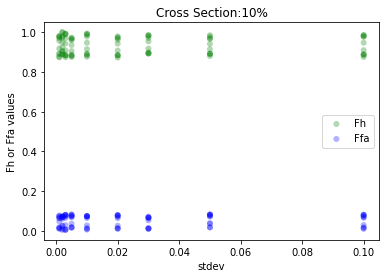

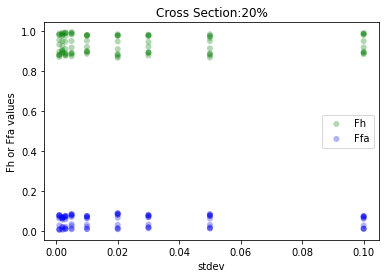

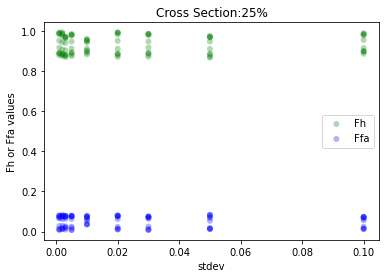

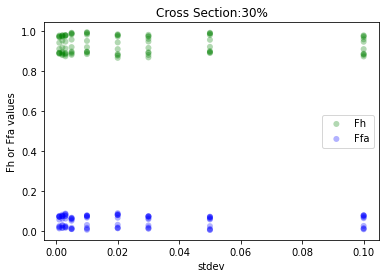

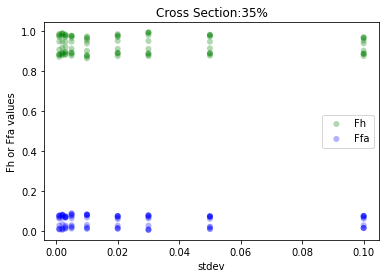

In [25]:
# [1] Display the Fh
# display the scatter plot of fh ffa with noise. 
# Use output Y' with X' as the reference dataset
noise_cross_section= [10,20,25,30,35]
for cross_section in range(len(noise_cross_section)):
    std_plot = [[i for _ in range(10)] for i in std]
    fig, ax = plt.subplots()
    plt.title("Cross Section:"+str(noise_cross_section[cross_section])+"%")
    ax.scatter(std_plot, Fh_noise_array1[cross_section], c="green", label="Fh", alpha=0.3, edgecolors='none')
#     print(Fh_noise_array1[cross_section])
    ax.scatter(std_plot, Ffa_noise_array1[cross_section], c="blue", label="Ffa", alpha=0.3, edgecolors='none')
    plt.xlabel("stdev")
    plt.ylabel("Fh or Ffa values")
    #plt.xscale("log")
    #plt.yscale("symlog")
    ax.legend()
    plt.show()

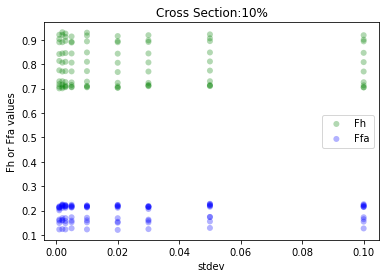

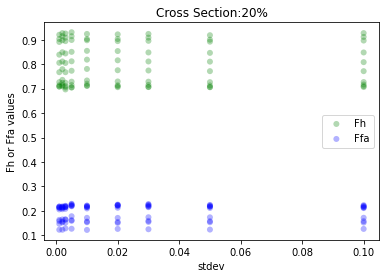

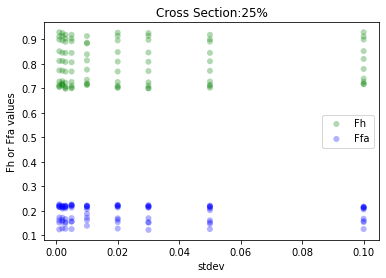

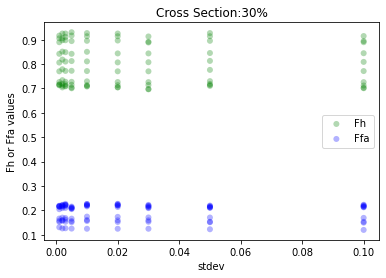

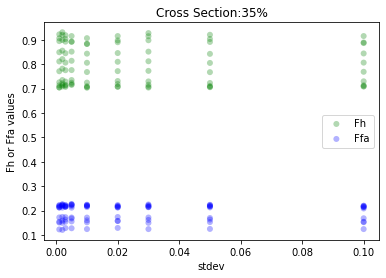

In [26]:
# [2] Display the Fh
# display the scatter plot of fh ffa with noise. 
# Use output Y' with X (instead of X') as the reference dataset
noise_cross_section= [10,20,25,30,35]
for cross_section in range(len(noise_cross_section)):
    std_plot = [[i for _ in range(10)] for i in std]
    fig, ax = plt.subplots()
    plt.title("Cross Section:"+str(noise_cross_section[cross_section])+"%")
    ax.scatter(std_plot, Fh_noise_array2[cross_section], c="green", label="Fh", alpha=0.3, edgecolors='none')
    ax.scatter(std_plot, Ffa_noise_array2[cross_section], c="blue", label="Ffa", alpha=0.3, edgecolors='none')
    plt.xlabel("stdev")
    plt.ylabel("Fh or Ffa values")
    #plt.xscale("log")
    #plt.yscale("symlog")
    ax.legend()
    plt.show()

In [ ]:
# Remoaining 
# 1. noise visualization
#    - graphs
#    - table
# 2. 4c Questions (report)
# TODO: Step 4c: Answer 2 questions from canvas
# Q1-a Yes there is mismatch
# Q1-b Should we compare Dataset2 output vs Dataset1 input?
# Why or why not?  (Justify your answer with analysis in the report generated in Step 8, below, and think about test, training, and validation datasets).
# We use Dataset1 to train out model. Dataset2 output (Y') should be seen as unseem dataset. We should refer 
# TODO visualize Y' (dataset2 output) with X (dataset1 input) to Justify answer (think about test, training)
# Q2 32x32

# Extra credit 
# 1. adjust hyperparameter
# 2. visualization

# Report
# 
